#Лабораторна робота 2

**Виконала** студентка групи КІ-41мп Додонова Марія.

##Завдання

1. Перевірити часовий ряд на стаціонарність/нестаціонарність за допомогою тестів.
2. Зробити декомпозицію часового ряду, визначити які складові містить часовий ряд.
3. Результат виконання лабораторної роботи оформити в звіт, додати до гугл класруму.
4. Всі статистичні характеристики, графіки додати до звіту.

##Виконання роботи

##Завантаження та попередня обробка датасету.
Детальніше розглянуто у лабораторній роботі 1.

Завантажимо набір даних Gurugram's Air Quality Index Time-Series Dataset із сайту kaggle, який представляє собою одновимірний часовий ряд.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pranaii/test-aqi")
df = pd.read_csv(path + "/sector_51_daily_aqi.csv")
df.columns = ["ID", "Date", "AQI"]

# Convert "Date" column to datetime and set it as the index
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Drop the "ID" column
df.drop("ID", axis=1, inplace=True)

df.head()

,AQI
Date,
2020-03-05,73.0
2020-03-06,55.0
2020-03-07,78.0
2020-03-08,120.0
2020-03-09,179.0


Зобразимо часовий ряд графічно.

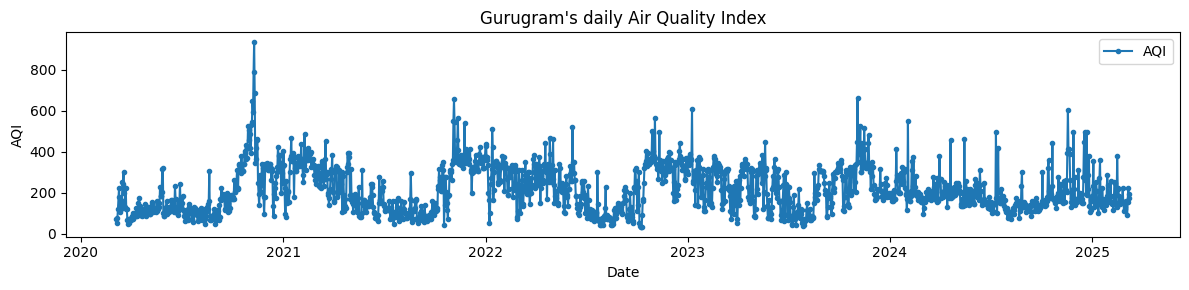

In [ ]:
# Plot the time series
def plot_time_series(df, column_name, label=None, smoothed_name=None,
                     lr_name=None, marker=None,
                     title="Gurugram's daily Air Quality Index"):
  plt.figure(figsize=(12, 3))

  # Plot the main time series data
  plt.plot(df[column_name], marker=marker, markersize=3,
           label=label or column_name)

  # Plot the smoothed data if available
  if smoothed_name is not None:
    plt.plot(df[smoothed_name], linestyle="--", label="Smoothed AQI")

  # Plot the linear regression if available
  if lr_name is not None:
    plt.plot(df[lr_name], label="Linear Regression")

  plt.xlabel("Date")
  plt.ylabel("AQI")
  plt.title(title)
  plt.legend()
  plt.tight_layout()

  plt.show()

# Plot original AQI with markers
plot_time_series(df, "AQI", marker="o")

Оскільки пропущених значень менше 10%, виконаємо заповнення пропусків середнім арифметичним. Для обчислення середнього арифметичного використовуватимемо по 2 значення з обох боків від пропущеного.

In [ ]:
# Show missing values count for each column
mask_na = df.isna()
mask_na.sum()

,0
AQI,2


In [ ]:
# Filling missing data by applying a rolling mean with a window size of 5
missing_series = df["AQI"].copy()
mask = missing_series.isna()
missing_series[mask] = missing_series.rolling(
    window=5, center=True, min_periods=1).mean()[mask]
df["AQI"] = missing_series

Також виконаємо згладжування даних за допомогою ковзного середнього.

<ipython-input-5-24618ec8a810>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  smoothed_data[i] = data[i]


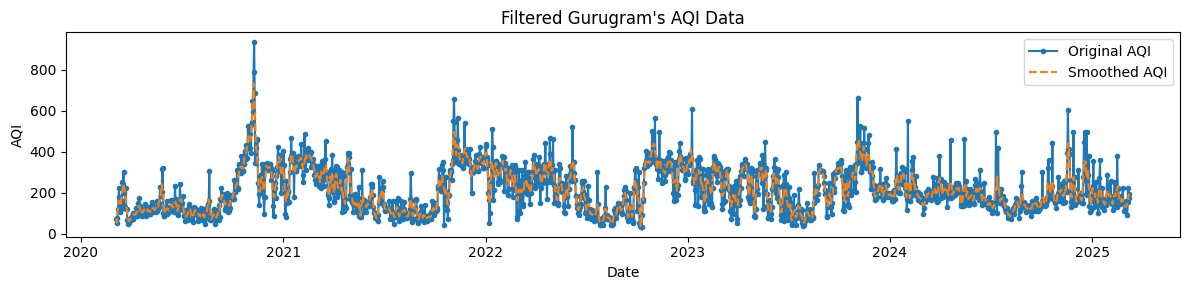

In [ ]:
# Using a custom mean filter to smooth the data
def mean_smooth(data, window_size=5):
  smoothed_data = np.zeros_like(data)
  for i in range(len(data)):
    if i < window_size // 2 or i >= len(data) - window_size // 2:
      smoothed_data[i] = data[i]
    else:
      # Apply mean smoothing within the window
      window_data = data[i - window_size // 2: i + window_size // 2 + 1]
      smoothed_data[i] = np.mean(window_data)
  return smoothed_data

# Apply smoothing to the AQI data
df["Smoothed"] = mean_smooth(df["AQI"])

# Plot original and smoothed AQI data
plot_time_series(df, "AQI", label="Original AQI", smoothed_name="Smoothed",
                 marker="o", title="Filtered Gurugram's AQI Data")

###Перевірка часового ряду на стаціонарність/нестаціонарність за допомогою тестів

Перевіримо наявність тренду візуально.

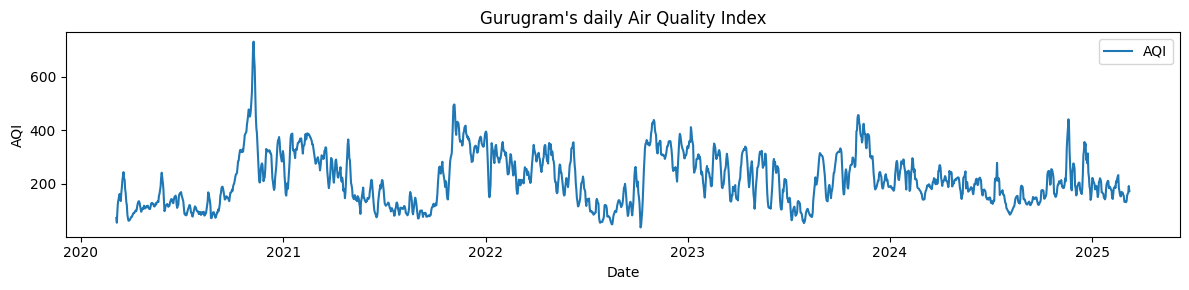

In [ ]:
plot_time_series(df, "Smoothed", label="AQI")

Можна припускати наяність невеликого негативного тренду, але значно більш помітною є сезонність.

Виконаємо аналіз тенду з використанням лінійної регресії для числової оцінки ряду. Також оцінимо швидкість зміни тренду, якщо він є.

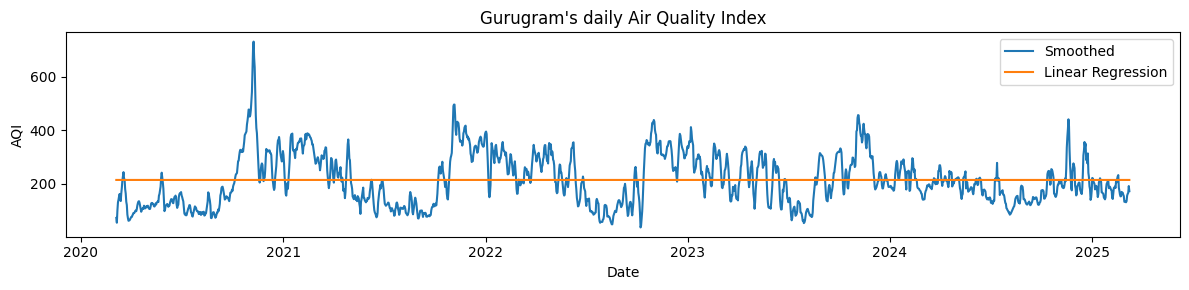

The slope coefficient (trend change rate): 0.00003 (3.24e-05) points per day.


In [ ]:
# Use linear regression to fit the data
coefficients = np.polyfit(range(df.shape[0]), df["Smoothed"], 1)
slope, intercept = coefficients

linear_regression = lambda x: slope * x + intercept
df["Linear_Regression"] = df["Smoothed"].apply(linear_regression)
plot_time_series(df, "Smoothed", lr_name="Linear_Regression")

# Print the slope coefficient (rate of trend change)
print(f"The slope coefficient (trend change rate): {slope:.5f} ({slope:.2e}) points per day.")

Малий від'ємний коефіцієнт вказує на відсутність тренду.

Перейдемо до статистичних тестів на стаціонарність. Виконаємо ADF-тест (Augmented Dickey-Fuller test).

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller (ADF) test for stationarity
result = adfuller(df["Smoothed"])

# Show ADF test statistics
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print(f"Lags Used: {result[2]}")
print(f"Number of Observations Used: {result[3]}")
print("Critical Values:")
for k, v in result[4].items():
  print(f" {k}: {v:.4f}")
print()

# Interpretation of ADF test result
if result[1] <= 0.05:
    print("The series is stationary. There is no trend.")
else:
    print("The series is not stationary. There is a trend.")

ADF Statistic: -3.5005
p-value: 0.0080
Lags Used: 25
Number of Observations Used: 1805
Critical Values:
 1%: -3.4340
 5%: -2.8631
 10%: -2.5676

The series is stationary. There is no trend.


Бачимо, що відповідно до ADF-тесту ряд є стаціонарним, отже тренду немає.

Застосуємо KPSS-тест (Kwiatkowski-Phillips-Schmidt-Shin test).

In [ ]:
from statsmodels.tsa.stattools import kpss

# Perform the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity
result = kpss(df["Smoothed"])

# Show KPSS test statistics
print(f"KPSS Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.2f}")
print(f"Lags Used: {result[2]}")
print("Critical Values:")
for k, v in result[3].items():
  print(f" {k}: {v:.3f}")
print()

# Interpretation of KPSS test result
if result[1] <= 0.05:
    print("The series is not stationary. There is a trend.")
else:
    print("The series is stationary. There is no trend.")
print()

KPSS Statistic: 0.1744
p-value: 0.10
Lags Used: 26
Critical Values:
 10%: 0.347
 5%: 0.463
 2.5%: 0.574
 1%: 0.739

The series is stationary. There is no trend.



<ipython-input-9-c0e891194095>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df["Smoothed"])


Бачимо, що відповідно до KPSS-тесту ряд є стаціонарним, отже тренду немає.

###Декомпозиція та визначення складових часового ряду

Оскільки сезонні коливання є значними, використаємо мультиплікативну декомпозицію ряду з періодом 365 днів (1 рік) та 30 днів (1 місяць).

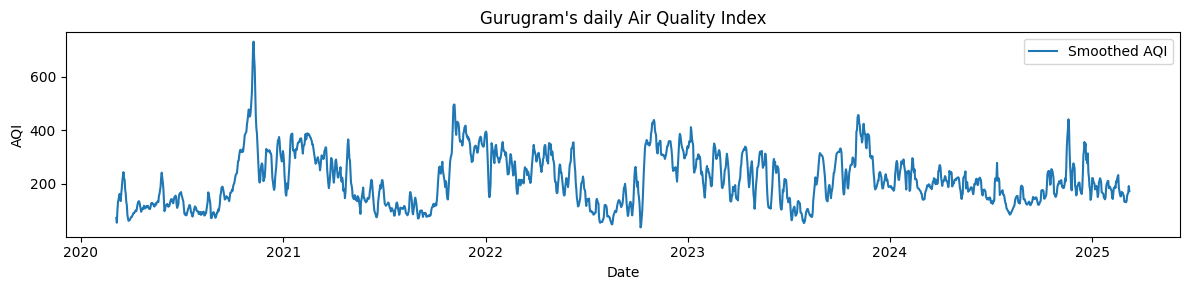

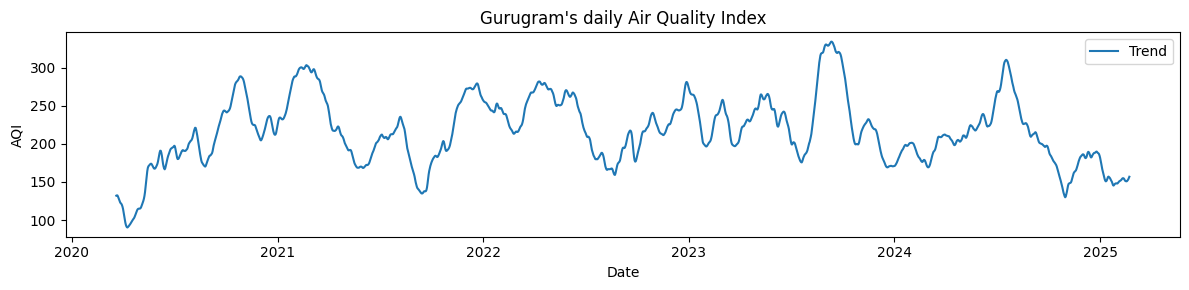

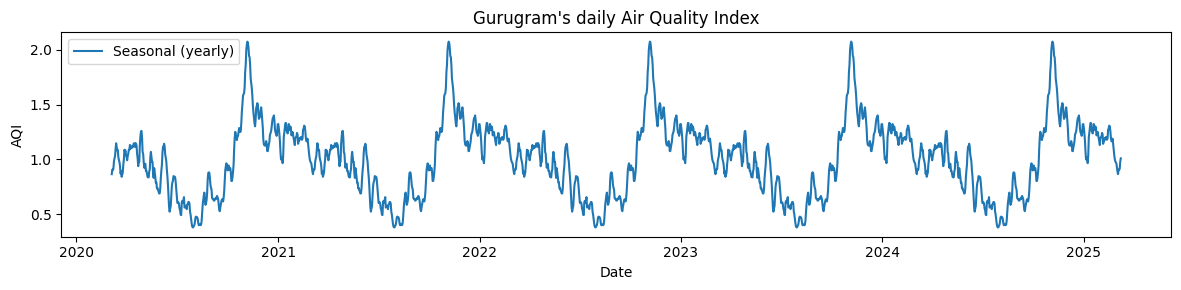

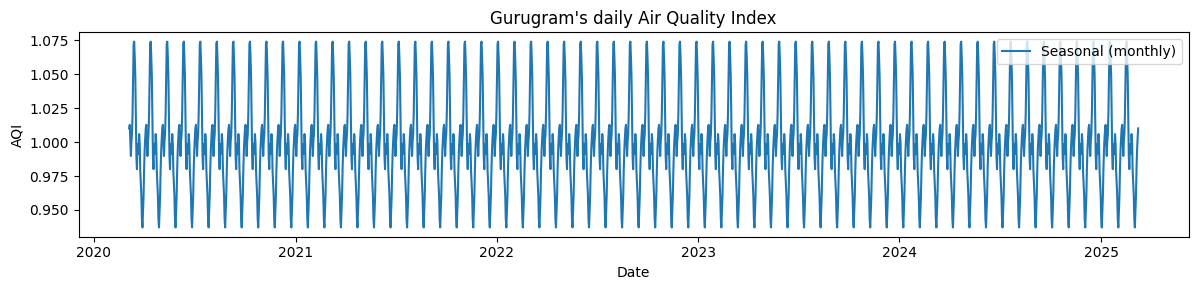

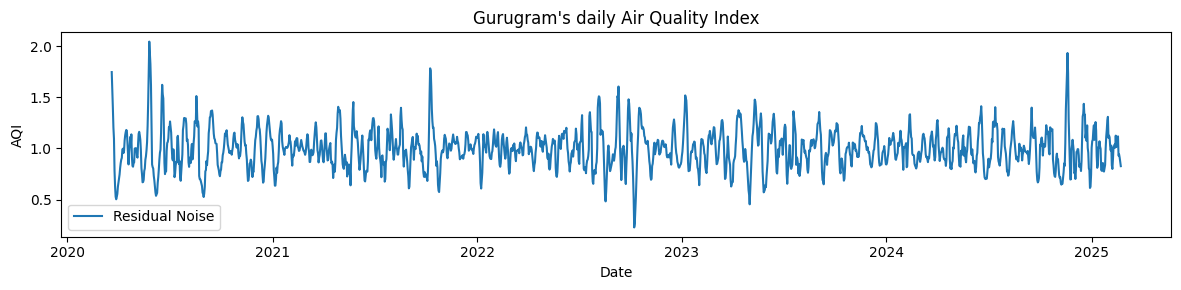

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform multiplicative decomposition for yearly seasonality (365 days)
result = seasonal_decompose(df[["Smoothed"]], model="multiplicative", period=365)
df["Seasonal_year"] = result.seasonal
df["new_Smoothed"] = df["Smoothed"] / df["Seasonal_year"]

# Perform multiplicative decomposition for monthly seasonality (30 days)
result = seasonal_decompose(df[["new_Smoothed"]], model="multiplicative", period=30)
df["Seasonal_month"] = result.seasonal

# Store the extracted trend and residuals
df["Trend"] = result.trend
df["Residuals"] = result.resid

# Plot the time series components
plot_time_series(df, "Smoothed", label="Smoothed AQI")
plot_time_series(df, "Trend")
plot_time_series(df, "Seasonal_year", label="Seasonal (yearly)")
plot_time_series(df, "Seasonal_month", label="Seasonal (monthly)")
plot_time_series(df, "Residuals", label="Residual Noise")

Збережемо дані.

In [ ]:
# Save the decomposed components to a CSV file
df = df[["AQI", "Smoothed", "Trend", "Seasonal_year", "Seasonal_month", "Residuals"]]
df.to_csv("decomposed_sector_51_daily_aqi.csv")

##Висновок

У ході лабораторної роботи було проведено аналіз та декомпозицію часового ряду значень індексу якості повітря (AQI) для міста Гуруграм в Індії. Спочатку було завантажено та передоброблено дані. Далі було застосовано лінійну регресію для визначення тренду в ряді. Результати показали, що тренд для ряду відсутній, оскільки значення коефіцієнта нахилу близьке до нуля. Для перевірки стаціонарності ряду були використані тести ADF та KPSS, які підтвердили, що ряд є стаціонарним і не має тренду.

Також у ході виконання роботи було проведено декомпозицію часового ряду за допомогою мультиплікативної моделі для виявлення сезонних компонент. Було отримано річну та місячну сезонності, які є очікуваними для даного ряду, оскільки він представляє щоденне значення AQI в Індії протягом кількох років. Графіки сезонності чітко демонструють повторювані патерни для кожного року та місяця.

Залишки після декомпозиції мають середнє значення близьке до 1 і розподілені навколо цього значення. Це свідчить про відсутність значних систематичних коливань та про коректне виділення моделлю основних компонентів часового ряду.

Отже, у результаті виконання лабораторної роботи було доведено, що ряд є стаціонарним, не має тренду, але має сезонні коливання, що є важливою інформацією для подальших прогнозів та аналізу індексу якості повітря в Гуруграмі.

## Джерела даних
Gurugram's Air Quality Index Time-Series Dataset отримано з Kaggle:  
https://www.kaggle.com/datasets/pranaii/test-aqi?select=sector_51_daily_aqi.csv.